In [36]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from google.colab import files
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
# import os
# uploaded = files.upload()

In [38]:
zip_path = "/content/dataset.zip"  # Change this to the actual filename

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")  # Extract to a directory


In [39]:
# Define dataset paths
dataset_path = "/content/dataset"
positive_dir = os.path.join(dataset_path, "Positive")  # Crack images
negative_dir = os.path.join(dataset_path, "Negative")  # No-crack images

# Get all image paths
crack_images = glob(os.path.join(positive_dir, "*.jpg"))
no_crack_images = glob(os.path.join(negative_dir, "*.jpg"))

# Print dataset info
print(f"Total Crack Images: {len(crack_images)}")
print(f"Total No-Crack Images: {len(no_crack_images)}")


Total Crack Images: 20000
Total No-Crack Images: 20000


<ipython-input-40-7a83c103eb35>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


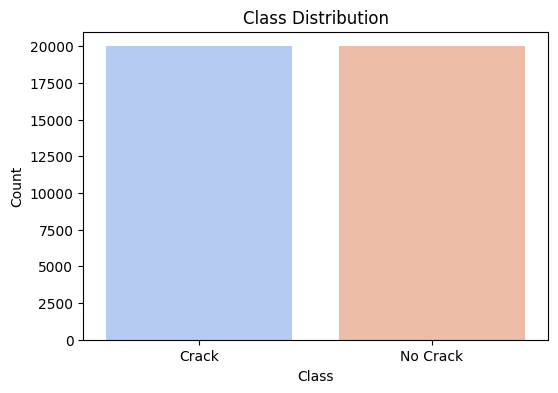

In [40]:
labels = ['Crack'] * len(crack_images) + ['No Crack'] * len(no_crack_images)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Checking Image Sizes**

Average Image Width: 227.00, Height: 227.00


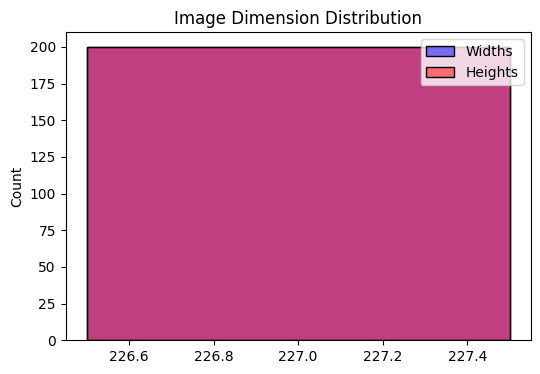

In [41]:
image_sizes = []
for img_path in crack_images[:100] + no_crack_images[:100]:  # Checking 100 images per class
    img = Image.open(img_path)
    image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"Average Image Width: {np.mean(widths):.2f}, Height: {np.mean(heights):.2f}")

plt.figure(figsize=(6, 4))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()


**Compute Image Stats(Mean & Std)**

In [42]:
def calculate_stats(image_list):
    means, stds = [], []

    for img_path in image_list[:500]:  # Checking first 500 images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        means.append(np.mean(img))
        stds.append(np.std(img))

    return np.mean(means), np.mean(stds)

crack_mean, crack_std = calculate_stats(crack_images)
no_crack_mean, no_crack_std = calculate_stats(no_crack_images)

print(f"Crack Images - Mean: {crack_mean:.3f}, Std: {crack_std:.3f}")
print(f"No Crack Images - Mean: {no_crack_mean:.3f}, Std: {no_crack_std:.3f}")


Crack Images - Mean: 0.641, Std: 0.122
No Crack Images - Mean: 0.709, Std: 0.034


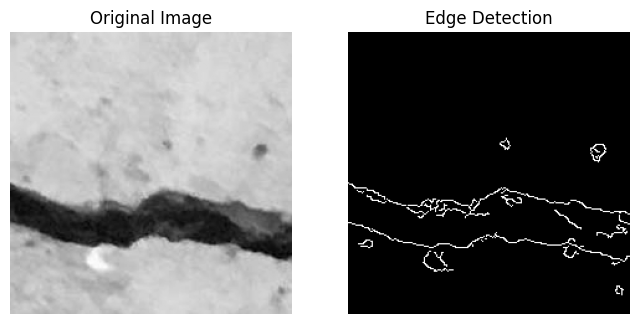

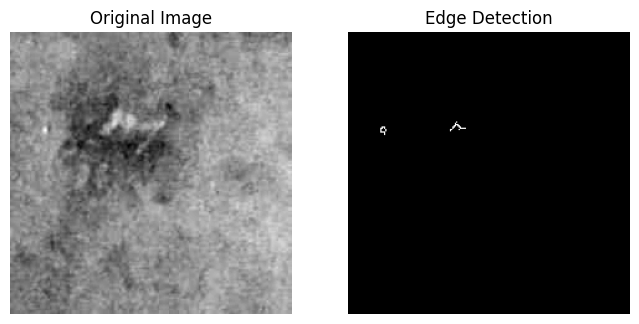

In [43]:
def show_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

# Test edge detection
show_edges(crack_images[0])
show_edges(no_crack_images[0])


📌 Preprocessing Steps

1️⃣ Load images & resize (Ensure all images have the same shape)

2️⃣ Convert to grayscale (optional)

3️⃣ Normalize pixel values (Scale values between 0-1 or -1 to 1)

4️⃣ Data Augmentation (Flip, rotate, zoom, etc.)

5️⃣ Prepare for model training (Create train-test splits & format data)



In [44]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def grayscale_conversion(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    gray_image = np.expand_dims(gray_image, axis=-1)  # Add a third dimension
    return np.repeat(gray_image, 3, axis=-1)  # Duplicate the single channel into 3 channels

def noise_removal(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Update the ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: noise_removal(grayscale_conversion(x)),  # Combine grayscale and noise removal
    validation_split=0.2
)

# Load training data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  # Load training set
)

# Load validation data
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # Load validation set
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [45]:
# Define data augmentation pipeline
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: noise_removal(grayscale_conversion(x)),  # Combine grayscale and noise removal
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Apply augmentation to training set
train_augmented = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 32000 images belonging to 2 classes.


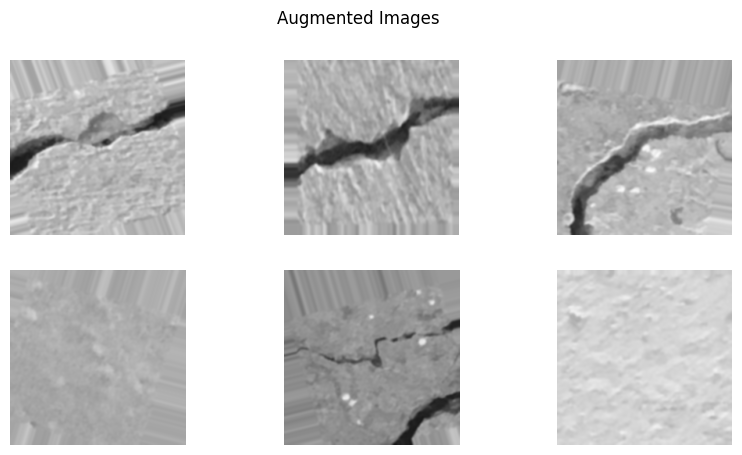

In [46]:
# Get a batch of images
augmented_images, _ = next(train_augmented)

# Plot some images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # Display grayscale images using cmap='gray'
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()